<a href="https://colab.research.google.com/github/mhz8240/Python-Projects/blob/main/Nfl_2022_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nfl_data_py
!pip install pandas
!pip install os
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [ ]:
pbp = nfl.import_pbp_data([2022])
pbp_2021 = nfl.import_pbp_data([2021])
win_totals = nfl.import_schedules([2022])

2022 done.
Downcasting floats.
2021 done.
Downcasting floats.


In [ ]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,None,None,NaN,None,NaN,,,,0,0
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,None,None,NaN,None,NaN,47969;53059;42500;46279;53575;48364;46253;5460...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11,11
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SHOTGUN,"1 RB, 2 TE, 2 WR",6.0,"3 DL, 4 LB, 4 DB",4.0,53536;43586;42371;53443;42500;44999;43433;3309...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",NaN,53536;43586;53443;42371;42500;44999;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11


In [ ]:
pbp_rp = pbp[((pbp['pass'] == 1) | (pbp['rush'] == 1)) & (pbp['play_type'] != 'no_play')]
pbp_rp = pbp_rp.dropna(subset = ['epa', 'posteam', 'defteam'])
pbp_rp.shape

(35430, 384)

In [ ]:
pass_epa = pbp_rp[(pbp['pass'] == 1)].groupby('posteam')['epa'].mean()
pass_epa = pass_epa.reset_index()
pass_epa.rename(columns={'epa':'pass_epa'}, inplace=True)
pass_epa.sort_values('pass_epa', ascending=False)

<ipython-input-15-7509ee15eb5b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pass_epa = pbp_rp[(pbp['pass'] == 1)].groupby('posteam')['epa'].mean()


,posteam,pass_epa
15,KC,0.287131
28,SF,0.172789
3,BUF,0.163970
10,DET,0.159487
6,CIN,0.141738
25,PHI,0.129805
14,JAX,0.099437
19,MIA,0.067718
20,MIN,0.059901
8,DAL,0.057906


In [ ]:
run_epa = pbp[pbp['rush'] == 1].groupby('posteam')['epa'].mean().reset_index()
run_epa = run_epa.sort_values('epa', ascending=False)
run_epa.rename(columns={'epa':'run_epa'}, inplace=True)
run_epa

,posteam,run_epa
25,PHI,0.094366
2,BAL,0.015354
1,ATL,0.006186
26,PIT,0.005845
23,NYG,0.005760
7,CLE,0.004358
5,CHI,-0.002024
4,CAR,-0.006957
11,GB,-0.009453
15,KC,-0.021943


In [ ]:
epa = pd.merge(pass_epa, run_epa, on='posteam')
epa

,posteam,pass_epa,run_epa
0,ARI,-0.102143,-0.079682
1,ATL,-0.016935,0.006186
2,BAL,-0.027962,0.015354
3,BUF,0.163970,-0.052620
4,CAR,-0.076010,-0.006957
5,CHI,-0.099015,-0.002024
6,CIN,0.141738,-0.049671
7,CLE,0.009557,0.004358
8,DAL,0.057906,-0.034671
9,DEN,-0.108860,-0.121433


In [ ]:
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logos

,team_abbr,team_logo_espn
0,ARI,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
1,ATL,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
2,BAL,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
3,BUF,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png
4,CAR,https://a.espncdn.com/i/teamlogos/nfl/500-dark...
5,CHI,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png
6,CIN,https://a.espncdn.com/i/teamlogos/nfl/500/cin.png
7,CLE,https://a.espncdn.com/i/teamlogos/nfl/500/cle.png
8,DAL,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png
9,DEN,https://a.espncdn.com/i/teamlogos/nfl/500/den.png


In [ ]:
logo_paths = []
team_abbr = []
if not os.path.exists('nfl_data'):
  print('here')
  os.makedirs('nfl_data')
for team in range(len(logos)):
  urllib.request.urlretrieve(logos['team_logo_espn'][team], f"nfl_data/{logos['team_abbr'][team]}.tif")
  logo_paths.append(f"nfl_data/{logos['team_abbr'][team]}.tif")
  team_abbr.append(logos['team_abbr'][team])
logo_data = pd.DataFrame({'team_abbr': team_abbr, 'logo':logo_paths})


here


# New Section
Add other data sets(current roster, etc.)


<Axes: xlabel='sack', ylabel='count'>

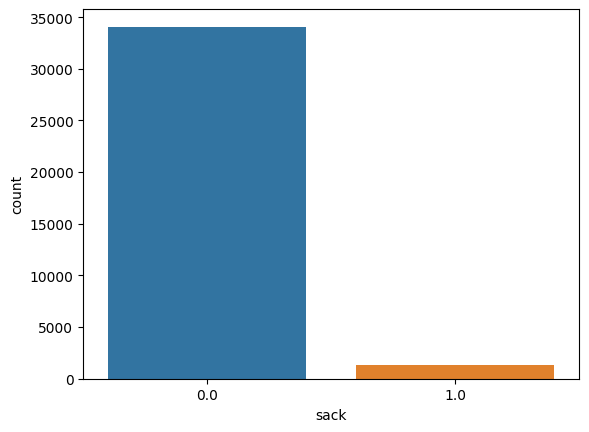

In [ ]:
import seaborn as sns
sns.countplot(x=pbp_rp['sack'])

In [ ]:
pbp_rp['obv_pass'] = pbp_rp.apply(lambda x : 1 if (x['down'] == 3 and x['ydstogo'] >= 6) else 0, axis=1)
pbp_rp[pbp_rp['obv_pass'] == 1]

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense,obv_pass
20,511.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,"1 RB, 1 TE, 3 WR",5.0,"2 DL, 3 LB, 6 DB",5.0,53536;43586;53443;42371;44999;46279;43433;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0038038;00...,11,11,1
24,595.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 1 LB, 6 DB",5.0,44929;47906;46211;54469;47786;46186;46155;5460...,00-0034978;00-0034753;00-0037838;00-0031330;00...,00-0033463;00-0034384;00-0037190;00-0035718;00...,11,11,1
36,868.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",5.0,53536;43586;53443;42371;44999;43433;54475;3309...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0038038;00...,11,11,1
56,1337.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,BAL,away,NYJ,...,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 2 LB, 5 DB",4.0,44929;47906;46211;54469;43301;47881;46186;4615...,00-0034978;00-0034753;00-0037838;00-0031330;00...,00-0033463;00-0034384;00-0037190;00-0032759;00...,11,11,1
63,1516.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,"0 RB, 2 TE, 3 WR",3.0,"2 DL, 3 LB, 6 DB",4.0,43586;53443;42371;42500;44999;46279;43433;5447...,00-0032466;00-0036979;00-0032234;00-0032134;00...,00-0033294;00-0026190;00-0038038;00-0036323;00...,11,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50032,1506.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 2 LB, 6 DB",NaN,52608;52546;35493;46118;47846;42406;43368;5258...,,,0,0,1
50047,1817.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,KC,away,PHI,...,"1 RB, 2 TE, 2 WR",6.0,"3 DL, 3 LB, 5 DB",NaN,48516;46213;47974;43367;46152;40011;46188;4132...,,,0,0,1
50076,2553.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,"1 RB, 1 TE, 3 WR",5.0,"4 DL, 1 LB, 6 DB",5.0,52608;52546;46118;47846;42406;43368;54600;5258...,,,0,0,1
50083,2710.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 2 LB, 6 DB",4.0,52608;52546;35493;46118;47846;42406;43368;5460...,,,0,0,1


# 2021 and 2022


In [ ]:
pbp.columns[60:70]

Index(['posteam_score_post', 'defteam_score_post', 'score_differential_post',
       'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob',
       'fg_prob', 'safety_prob', 'td_prob'],
      dtype='object')

In [ ]:
pbp_clean = pbp[((pbp['rush'] == 1) | (pbp['pass'] == 1)) & (pbp['play_type'] != 'no_play')]
pbp_clean
off_epa = pbp_clean.groupby('posteam')[['epa']].mean()
off_epa.reset_index(inplace=True)
off_epa.rename(columns = {'epa': 'off_epa', 'posteam':'team'}, inplace=True)

# off_epa

def_epa = pbp_clean.groupby('defteam')[['epa']].mean()
def_epa.reset_index(inplace=True)
def_epa.rename(columns = {'epa':'def_epa', 'defteam':'team'}, inplace=True)
def_epa

total_epa = off_epa.merge(def_epa, on='team')
total_epa

,team,off_epa,def_epa
0,ARI,-0.088105,0.015700
1,ATL,0.004900,0.079850
2,BAL,-0.001189,-0.010767
3,BUF,0.093456,-0.045535
4,CAR,-0.034510,0.002920
5,CHI,-0.045903,0.118119
6,CIN,0.081288,-0.042267
7,CLE,0.012449,0.013787
8,DAL,0.026683,-0.088171
9,DEN,-0.108754,-0.048807


In [ ]:
win_totals = nfl.import_schedules([2022])
win_totals['away_win'] = win_totals.apply(lambda row : 0 if row['result']>0 else 1, axis=1)
win_totals['home_win'] = win_totals.apply(lambda row : 1 if row['result']>0 else 0, axis=1)
home_wins = win_totals.groupby('home_team')['home_win'].sum().reset_index()
away_wins = win_totals.groupby('away_team')['away_win'].sum().reset_index()
wins = (home_wins['home_win'] + away_wins['away_win']).reset_index()
wins.drop(columns='index', inplace=True)
wins.rename(columns={0:'wins'},inplace=True)
teams = home_wins[['home_team']].rename(columns={'home_team':'team'})
wins = teams.join(wins)
wins

,team,wins
0,ARI,4
1,ATL,7
2,BAL,10
3,BUF,14
4,CAR,7
5,CHI,3
6,CIN,14
7,CLE,7
8,DAL,13
9,DEN,5


In [ ]:
win_totals.shape

(284, 48)

In [ ]:
lr = LinearRegression()
x = total_epa[['off_epa','def_epa']]
y=wins['wins']
lr.fit(x,y)
lr.predict([[-0.05, 0.05]])
# # lr.score(x,y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([5.8274518])

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=0.3, random_state=1)
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

predictions = pd.DataFrame(zip(pred,y_test), columns=['pred', 'actual'])
# predictions



In [ ]:
predictions


,pred,actual
0,8.047308,9
1,14.325727,14
2,9.605289,7
3,7.270654,6
4,8.541080,10
5,9.546165,10
6,10.047555,8
7,15.498703,15
8,10.503450,9
9,11.093223,10


In [ ]:
win_totals_2021 = nfl.import_schedules([2021])
win_totals_2021['away_win'] = win_totals_2021.apply(lambda row : 0 if row['result']>0 else 1, axis=1)
win_totals_2021['home_win'] = win_totals_2021.apply(lambda row : 1 if row['result']>0 else 0, axis=1)
home_wins = win_totals_2021.groupby('home_team')['home_win'].sum().reset_index()
away_wins = win_totals_2021.groupby('away_team')['away_win'].sum().reset_index()
wins_2021 = (home_wins['home_win'] + away_wins['away_win']).reset_index()
wins_2021.drop(columns='index', inplace=True)
wins_2021.rename(columns={0:'wins'},inplace=True)
teams = home_wins[['home_team']].rename(columns={'home_team':'team'})
wins_2021 = teams.join(wins_2021)
wins_2021

,team,wins
0,ARI,11
1,ATL,7
2,BAL,8
3,BUF,12
4,CAR,5
5,CHI,6
6,CIN,13
7,CLE,8
8,DAL,12
9,DEN,7


In [ ]:
pbp_2021 = nfl.import_pbp_data([2021])


2021 done.
Downcasting floats.


In [ ]:
pbp_clean = pbp_2021[(pbp_2021['play_type'] != 'qb_kneel') & (pbp_2021['play_type'] != 'no_play') ].dropna(subset=['play_type'])
off_epa_2021 = pbp_clean.groupby('posteam')['epa'].mean().reset_index()
off_epa_2021.rename(columns={'epa':'off_epa', 'posteam':'team'}, inplace=True)
def_epa_2021 = pbp_clean.groupby('defteam')['epa'].mean().reset_index()
def_epa_2021.rename(columns={'epa':'def_epa', 'defteam':'team'},inplace=True)
# def_epa_2021

epa = pd.merge(off_epa_2021,def_epa_2021,on='team')


In [ ]:
### narrow down EPA (two-minute, fourth q, clutch time, etc.)
#fhalf_twomin
fhalf_twomin = pbp_clean[(pbp_clean['half_seconds_remaining']<=240.0) & (pbp_clean['game_half'] == 'Half1')]
off_epa_fhalf_twomin = fhalf_twomin.groupby('posteam')[['epa', 'wpa']].mean()
def_epa_fhalf_twomin = fhalf_twomin.groupby('defteam')[['epa', 'wpa']].mean()

fourthq = pbp_clean[(pbp_clean['qtr'] == 4) & (abs(pbp_clean['score_differential']) <= 8 )]
#4thq_oneposs
fourthq_off_epa = fourthq.groupby("posteam")[['epa', 'wpa']].mean()
fourthq_def_epa = fourthq.groupby("defteam")[['epa', 'wpa']].mean()
#clutch
clutch = fourthq[fourthq['game_seconds_remaining'] <= 300]
clutch_off_epa = clutch.groupby('posteam')[['epa', 'wpa']].mean()
clutch_def_epa = clutch.groupby('defteam')[['epa', 'wpa']].mean()
clutch_off_epa
# off_epa_fhalf_twomin.iloc[-75:-15, 5:25]

,epa,wpa
posteam,,
ARI,0.010898,-0.006506
ATL,0.046242,0.019545
BAL,0.262816,0.012351
BUF,0.197536,0.008100
CAR,-0.129704,-0.006901
CHI,0.308702,0.023225
CIN,0.034768,0.009504
CLE,-0.182913,-0.014921
DAL,0.179594,0.014997


# Testing Section

In [ ]:
# pbp.iloc[-75:-15, 5:25]
pbp['play_type'].value_counts()

pass           20393
run            15037
no_play         4563
kickoff         2835
punt            2294
extra_point     1253
field_goal      1105
qb_kneel         442
qb_spike          63
Name: play_type, dtype: int64

In [ ]:
seasonal = nfl.import_seasonal_data([2021])

/usr/local/lib/python3.10/dist-packages/nfl_data_py/__init__.py:291: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ['player_id', 'season']).sum().reset_index()
/usr/local/lib/python3.10/dist-packages/nfl_data_py/__init__.py:309: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  szn = data.groupby(['player_id', 'season', 'season_type']).sum().reset_index().merge(


In [ ]:
seasonal

,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh
0,00-0019596,2021,REG,485,719,5316.0,43,12.0,22.0,144.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.195705
1,00-0022824,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022883
2,00-0022924,2021,REG,390,605,3740.0,22,10.0,38.0,239.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164071
3,00-0023459,2021,REG,366,531,4115.0,37,4.0,30.0,188.0,...,0.000000,0.001939,-0.000923,0.000000,0.000000,0.000000,-0.000461,-0.000738,-0.007156,0.207297
4,00-0023682,2021,REG,3,6,13.0,0,0.0,1.0,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,00-0037004,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.015625,0.047322,0.010076,0.000000,0.000000,0.000000,0.005038,0.008060,0.068966,0.006251
651,00-0037005,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.048985,0.165644,0.063003,0.090909,0.074627,0.075862,0.076956,0.068584,0.360000,0.053186
652,00-0037011,2021,REG,0,0,0.0,0,0.0,0.0,0.0,...,0.036836,0.054752,0.023974,0.000000,0.030303,0.026786,0.011987,0.019180,0.177165,0.015674
653,00-0037012,2021,REG,41,71,603.0,5,2.0,4.0,15.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119558


In [ ]:
win_totals.iloc[:,40:45]

,away_coach,home_coach,referee,stadium_id,stadium
6137,Sean McDermott,Sean McVay,Carl Cheffers,LAX01,SoFi Stadium
6138,Dennis Allen,Arthur Smith,Alex Kemp,ATL97,Mercedes-Benz Stadium
6139,Kevin Stefanski,Matt Rhule,Brad Rogers,CAR00,Bank of America Stadium
6140,Kyle Shanahan,Matt Eberflus,Clay Martin,CHI98,Soldier Field
6141,Mike Tomlin,Zac Taylor,Shawn Hochuli,CIN00,Paycor Stadium
...,...,...,...,...,...
6416,Zac Taylor,Sean McDermott,Carl Cheffers,BUF00,New Era Field
6417,Mike McCarthy,Kyle Shanahan,Bill Vinovich,SFO01,Levi's Stadium
6418,Kyle Shanahan,Nick Sirianni,John Hussey,PHI00,Lincoln Financial Field
6419,Zac Taylor,Andy Reid,Ron Torbert,KAN00,GEHA Field at Arrowhead Stadium
